# Call Center Summarization: Source Attribution, Feature Attribution & Feature Importance

Complete, self‑contained, reproducible example that: 
1. Simulates multiple multi-speaker call center transcripts.
2. Generates abstractive summaries with a seq2seq transformer (DistilBART by default).
3. Captures cross-attention for a lightweight token-level attribution heuristic.
4. Performs source attribution: aligns each summary sentence to the most relevant source sentences (TF‑IDF similarity + optional attention weighting).
5. Computes feature attribution scores (token & sentence importance) from aggregated cross-attention.
6. Derives higher-level engineered features (length, speaker dynamics, sentiment proxies) and estimates their importance for explaining variation in summary quality metrics.
7. Reports evaluation metrics (compression ratio, coverage, novelty, simple ROUGE-L if library available).
8. Visualizes: attention heatmap, per-token importance bar, sentence attribution table, global feature importances.

> NOTE: Attention ≠ ground-truth explanation (Jain & Wallace, 2019). Attributions here are heuristics for exploration, not causal proof.

### Reproducibility
* Deterministic seeds (where possible).
* CPU-friendly defaults; switch to GPU if available.
* Minimal external dependencies.

## 1. Environment & Dependencies
Install lightweight libraries. (Skip if already available.)

In [1]:
# If running first time, uncomment the below line.
# !pip install --quiet transformers torch seaborn matplotlib pandas numpy scikit-learn wordcloud rouge-score

## 2. Imports, Configuration & Utilities

In [1]:
import os, math, random, textwrap, json
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, GenerationConfig
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
try:
    from rouge_score import rouge_scorer
    ROUGE_AVAILABLE = True
except ImportError:
    ROUGE_AVAILABLE = False
    print("rouge-score not available. Will skip ROUGE metrics.")

random.seed(42); np.random.seed(42); torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'sshleifer/distilbart-cnn-6-6'  # Small summarization model
print('Using device:', device)

Using device: cpu


## 3. Simulate Multi-Speaker Call Center Transcripts
We create synthetic conversations with agent / customer turns and simple labels (billing, tech-support, cancellation, sales).

In [2]:
CALL_TYPES = ['billing','tech_support','cancellation','sales']
AGENT_PREFIX='Agent:'; CUST_PREFIX='Customer:'

def simulate_call(call_type:str, n_turns:int=8)->str:
    issues = {
        'billing': ['charged twice','refund request','incorrect fee','invoice mismatch'],
        'tech_support': ['router offline','slow internet','error code 504','dropped connection'],
        'cancellation': ['want to cancel','closing account','dissatisfied with service','fee too high'],
        'sales': ['upgrade plan','new subscription','promotion details','bundle discount']
    }
    outcomes = {
        'billing': 'refund will be processed',
        'tech_support': 'technician scheduled',
        'cancellation': 'retention offer provided',
        'sales': 'plan upgrade initiated'
    }
    turns=[]
    for i in range(n_turns):
        if i%2==0: # customer
            issue=random.choice(issues[call_type])
            turns.append(f'{CUST_PREFIX} I have a {issue} situation today.')
        else: # agent
            if i < n_turns-1:
                turns.append(f'{AGENT_PREFIX} I can help, let me gather more details about that.')
            else:
                turns.append(f'{AGENT_PREFIX} Summary: {outcomes[call_type]}. Anything else?')
    return ' '.join(turns)

def build_dataset(n_calls:int=25)->pd.DataFrame:
    data=[]
    for i in range(n_calls):
        ctype=random.choice(CALL_TYPES)
        txt=simulate_call(ctype, n_turns=random.randint(6,12))
        data.append({'call_id':f'call_{i+1}','call_type':ctype,'transcript':txt})
    return pd.DataFrame(data)

df = build_dataset(20)
df.head()

,call_id,call_type,transcript
0,call_1,billing,Customer: I have a incorrect fee situation tod...
1,call_2,tech_support,Customer: I have a router offline situation to...
2,call_3,tech_support,Customer: I have a router offline situation to...
3,call_4,sales,Customer: I have a promotion details situation...
4,call_5,cancellation,Customer: I have a closing account situation t...


## 4. Load Summarization Model
Enable output attentions to later aggregate cross-attention for attribution heuristics.

In [3]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, output_attentions=True).to(device)
model.eval()
print('Model loaded.')

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Model loaded.


## 5. Summarization with Cross-Attention Capture
Function returns summary text, cross-attention tensors, and token metadata.

In [4]:
def summarize(text:str, max_new_tokens:int=64):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    gen_cfg = GenerationConfig(max_new_tokens=max_new_tokens, do_sample=False)
    with torch.no_grad():
        output = model.generate(**inputs, return_dict_in_generate=True, output_attentions=True, generation_config=gen_cfg)
    summary = tokenizer.decode(output.sequences[0], skip_special_tokens=True)
    cross_attn = output.cross_attentions  # tuple(n_layers) each: (batch, n_heads, tgt_len, src_len)
    return summary, cross_attn, inputs, output.sequences

def aggregate_cross_attention(cross_attn)->np.ndarray:
    if not cross_attn: return None
    layers = []
    for layer_tensor in cross_attn:
        # layer_tensor shape: (batch, heads, tgt, src)
        layers.append(layer_tensor[0].mean(dim=0).cpu().numpy())  # heads mean -> (tgt, src)
    return np.mean(np.stack(layers, axis=0), axis=0)  # (tgt, src)

def decode_tokens(inputs, seqs)->Tuple[List[str],List[str]]:
    src_ids = inputs['input_ids'][0].cpu().tolist()
    tgt_ids = seqs[0].cpu().tolist()
    src_tokens = tokenizer.convert_ids_to_tokens(src_ids)
    tgt_tokens = tokenizer.convert_ids_to_tokens(tgt_ids)
    # strip special tokens
    src_tokens = [t for t in src_tokens if t not in tokenizer.all_special_tokens]
    tgt_tokens = [t for t in tgt_tokens if t not in tokenizer.all_special_tokens]
    return src_tokens, tgt_tokens

## 6. Run Summaries for All Calls & Store Artifacts

In [5]:
records=[]
for _, row in df.iterrows():
    summary, cross_attn, inputs, seqs = summarize(row.transcript)
    attn_matrix = aggregate_cross_attention(cross_attn)
    records.append({
        'call_id':row.call_id,
        'call_type':row.call_type,
        'transcript':row.transcript,
        'summary':summary,
        'attention':attn_matrix,
        'inputs':inputs,
        'seqs':seqs
    })

summ_df = pd.DataFrame(records)
summ_df.head()[['call_id','call_type','summary']]

`generation_config` default values have been modified to match model-specific defaults: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2, 'output_attentions': True, 'return_dict_in_generate': True, 'pad_token_id': 1, 'bos_token_id': 0, 'eos_token_id': 2, 'decoder_start_token_id': 2}. If this is not desired, please set these values explicitly.


,call_id,call_type,summary
0,call_1,billing,Customer: I have a refund request situation to...
1,call_2,tech_support,Customer: I have a router offline situation t...
2,call_3,tech_support,Customer: I have a slow internet situation tod...
3,call_4,sales,Customer: I have a promotion details situation...
4,call_5,cancellation,Customer: I have a dissatisfied with service ...


## 7. Source Attribution (Sentence-Level)
Approach: 
1. Split transcript into sentences (simple period split).
2. Split summary into sentences.
3. Use TF-IDF vectors -> cosine similarity summary sentence vs source sentences.
4. (Optional) Re-weight scores by average attention of source sentence tokens if attention available.
5. Keep top-k source sentences per summary sentence.

In [6]:
import re
SENT_SPLIT = re.compile(r'(?<=[.!?]) +')

def sentence_split(text:str)->List[str]:
    return [s.strip() for s in SENT_SPLIT.split(text) if s.strip()]

def sentence_source_attribution(transcript:str, summary:str, attn_matrix:np.ndarray, inputs, seqs, top_k:int=2):
    src_sents = sentence_split(transcript)
    sum_sents = sentence_split(summary)
    if not src_sents or not sum_sents: return []
    
    corpus = src_sents + sum_sents
    tfidf = TfidfVectorizer(stop_words='english').fit_transform(corpus)
    src_vecs = tfidf[:len(src_sents)]
    sum_vecs = tfidf[len(src_sents):]
    sim = cosine_similarity(sum_vecs, src_vecs)  # (n_sum, n_src)
    
    # Optional attention weighting: average attention per source sentence tokens
    if attn_matrix is not None:
        # Map source tokens to sentences by simple substring matching count
        src_tokens, tgt_tokens = decode_tokens(inputs, seqs)
        joined = ' '.join(src_tokens)
        # crude sentence token coverage proportion as weight
        sent_weights=[]
        for s in src_sents:
            toks = s.lower().split()
            if not toks: sent_weights.append(1.0); continue
            count = sum(joined.lower().count(t) for t in toks)
            sent_weights.append(1.0 + math.log(1+count))
        sent_weights = np.array(sent_weights)
        sim = sim * sent_weights  # broadcast
    
    attributions=[]
    for i, sum_sent in enumerate(sum_sents):
        idxs = np.argsort(sim[i])[::-1][:top_k]
        sources=[{'source_sentence':src_sents[j],'score':float(sim[i,j])} for j in idxs]
        attributions.append({'summary_sentence':sum_sent,'aligned_sources':sources})
    return attributions

# Example for first call
example_attr = sentence_source_attribution(
    summ_df.transcript.iloc[0], summ_df.summary.iloc[0], summ_df.attention.iloc[0], 
    summ_df.inputs.iloc[0], summ_df.seqs.iloc[0])
example_attr

[{'summary_sentence': 'Customer: I have a refund request situation today.',
  'aligned_sources': [{'source_sentence': 'Customer: I have a refund request situation today.',
    'score': 5.007333185232471},
   {'source_sentence': 'Customer: I have a refund request situation today.',
    'score': 5.007333185232471}]},
 {'summary_sentence': 'Agent: I can help, let me gather more details about that .',
  'aligned_sources': [{'source_sentence': 'Agent: I can help, let me gather more details about that.',
    'score': 4.526360524616162},
   {'source_sentence': 'Agent: I can help, let me gather more details about that.',
    'score': 4.526360524616162}]},
 {'summary_sentence': 'Agent: refund will be processed.',
  'aligned_sources': [{'source_sentence': 'Agent: Summary: refund will be processed.',
    'score': 2.152889724006821},
   {'source_sentence': 'Customer: I have a refund request situation today.',
    'score': 1.1066296506865008}]},
 {'summary_sentence': 'Anything else?',
  'aligned_so

## 8. Token & Sentence Feature Attribution from Cross-Attention
We derive heuristic importance: for each source token its cumulative attention mass across target tokens. Then aggregate to sentences.

In [8]:
def token_importance(attn_matrix:np.ndarray, inputs, seqs)->pd.DataFrame:
    if attn_matrix is None: return pd.DataFrame()
    src_tokens, tgt_tokens = decode_tokens(inputs, seqs)
    # sum over target axis -> importance per source token
    scores = attn_matrix.sum(axis=0)
    # Ensure scores is 1D and matches source tokens length
    if scores.ndim > 1:
        scores = scores.flatten()
    scores = scores[:len(src_tokens)]
    
    # Create a proper DataFrame with matching lengths
    min_len = min(len(src_tokens), len(scores))
    df_imp = pd.DataFrame({'token':src_tokens[:min_len],'importance':scores[:min_len]})
    
    # Merge subword pieces (BPE) heuristically by stripping special markers
    agg={}
    for tok, sc in zip(df_imp.token, df_imp.importance):
        norm = tok.replace('Ġ','').replace('##','')
        if not norm: continue
        agg[norm] = agg.get(norm,0.0)+float(sc)
    merged = pd.DataFrame({'token':list(agg.keys()),'importance':list(agg.values())})
    merged.sort_values('importance', ascending=False, inplace=True)
    return merged.head(25)

def sentence_importance(transcript:str, token_imp:pd.DataFrame)->pd.DataFrame:
    if token_imp.empty: return pd.DataFrame()
    sents = sentence_split(transcript)
    rows=[]
    for s in sents:
        score=0.0
        words=set(w.lower().strip('.,!?') for w in s.split())
        for _, r in token_imp.iterrows():
            if r.token.lower() in words: score += r.importance
        rows.append({'sentence':s,'importance':score})
    df_s = pd.DataFrame(rows).sort_values('importance', ascending=False)
    return df_s

tok_imp_example = token_importance(summ_df.attention.iloc[0], summ_df.inputs.iloc[0], summ_df.seqs.iloc[0])
sent_imp_example = sentence_importance(summ_df.transcript.iloc[0], tok_imp_example)
print("Token importance:")
print(tok_imp_example.head())
print("\nSentence importance:")
print(sent_imp_example.head())

Token importance:
       token  importance
0   Customer    4.397788
10     Agent    2.563415
27  Anything    0.867793
1          :    0.644868
9          .    0.612622

Sentence importance:
                                            sentence  importance
2  Customer: I have a refund request situation to...    2.170561
4  Customer: I have a refund request situation to...    2.170561
0  Customer: I have a incorrect fee situation today.    2.142599
1  Agent: I can help, let me gather more details ...    1.960584
3  Agent: I can help, let me gather more details ...    1.960584


## 9. Evaluation Metrics per Call
We compute: compression ratio, coverage (portion of summary content words present in source), novelty (summary tokens not in source), simple ROUGE-L (if available).

In [9]:
def quality_metrics(row)->Dict[str,float]:
    src=row.transcript; summ=row.summary
    src_tokens=[w.lower().strip('.,!?') for w in src.split()]
    summ_tokens=[w.lower().strip('.,!?') for w in summ.split()]
    src_set=set(src_tokens); summ_set=set(summ_tokens)
    compression = len(summ_tokens)/max(1,len(src_tokens))
    coverage = len([t for t in summ_set if t in src_set])/max(1,len(summ_set))
    novelty = len([t for t in summ_set if t not in src_set])/max(1,len(summ_set))
    
    if ROUGE_AVAILABLE:
        try:
            scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
            rougeL = scorer.score(src, summ)['rougeL'].fmeasure
        except Exception:
            rougeL = float('nan')
    else:
        rougeL = float('nan')
    
    return {'compression':compression,'coverage':coverage,'novelty':novelty,'rougeL':rougeL}

metric_rows=[]
for _, r in summ_df.iterrows():
    metric_rows.append({'call_id':r.call_id, **quality_metrics(r)})

metrics_df = pd.DataFrame(metric_rows)
metrics_df.head()

,call_id,compression,coverage,novelty,rougeL
0,call_1,0.777778,0.781250,0.218750,0.553191
1,call_2,0.398058,0.645161,0.354839,0.461538
2,call_3,0.630769,0.689655,0.310345,0.647619
3,call_4,0.417582,0.758621,0.241379,0.515625
4,call_5,0.676471,0.718750,0.281250,0.625000


## 10. Higher-Level Feature Engineering (per Call)
Features: transcript length, #turns, average turn length, call_type (one-hot), customer_turn_ratio.

In [10]:
def engineered_features(row)->Dict[str,float]:
    turns = [t for t in row.transcript.split(AGENT_PREFIX) if t.strip()]
    n_tokens = len(row.transcript.split())
    n_turns = row.transcript.count('Customer:') + row.transcript.count('Agent:')
    cust_turns = row.transcript.count('Customer:')
    avg_turn_len = n_tokens / max(1,n_turns)
    cust_ratio = cust_turns / max(1,n_turns)
    return {
        'n_tokens':n_tokens,
        'n_turns':n_turns,
        'avg_turn_len':avg_turn_len,
        'cust_turn_ratio':cust_ratio
    }

feat_rows=[]
for _, r in summ_df.iterrows():
    fr = engineered_features(r)
    fr['call_id']=r.call_id
    fr['call_type']=r.call_type
    feat_rows.append(fr)

features_df = pd.DataFrame(feat_rows)
features_df.head()

,n_tokens,n_turns,avg_turn_len,cust_turn_ratio,call_id,call_type
0,54,6,9.000000,0.500000,call_1,billing
1,103,11,9.363636,0.545455,call_2,tech_support
2,65,7,9.285714,0.571429,call_3,tech_support
3,91,10,9.100000,0.500000,call_4,sales
4,68,7,9.714286,0.571429,call_5,cancellation


## 11. Feature Importance for Explaining Summary Quality
Train a simple RandomForest regressor to predict coverage (as proxy for quality) from engineered features. Importance scores are model-based (Gini).

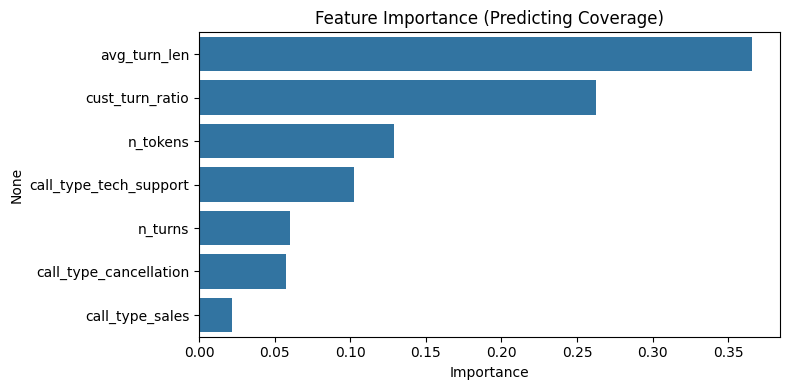

Top feature importances:
avg_turn_len              0.365981
cust_turn_ratio           0.262713
n_tokens                  0.128878
call_type_tech_support    0.102678
n_turns                   0.060180
call_type_cancellation    0.057705
call_type_sales           0.021865
dtype: float64


In [11]:
data = features_df.merge(metrics_df, on='call_id')
# One-hot call_type
data = pd.get_dummies(data, columns=['call_type'], drop_first=True)

# Use coverage as target since ROUGE might not be available
target = data['coverage'].fillna(data['coverage'].mean())
X = data.drop(columns=['call_id','compression','coverage','novelty','rougeL'])

if len(X) > 0 and len(target) > 0:
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X, target)
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    
    plt.figure(figsize=(8,4))
    sns.barplot(x=importances.values, y=importances.index)
    plt.title('Feature Importance (Predicting Coverage)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("Top feature importances:")
    print(importances.head(10))
else:
    print("Insufficient data for feature importance analysis")

## 12. Visualization Helpers (Attention Heatmap & Word Cloud)

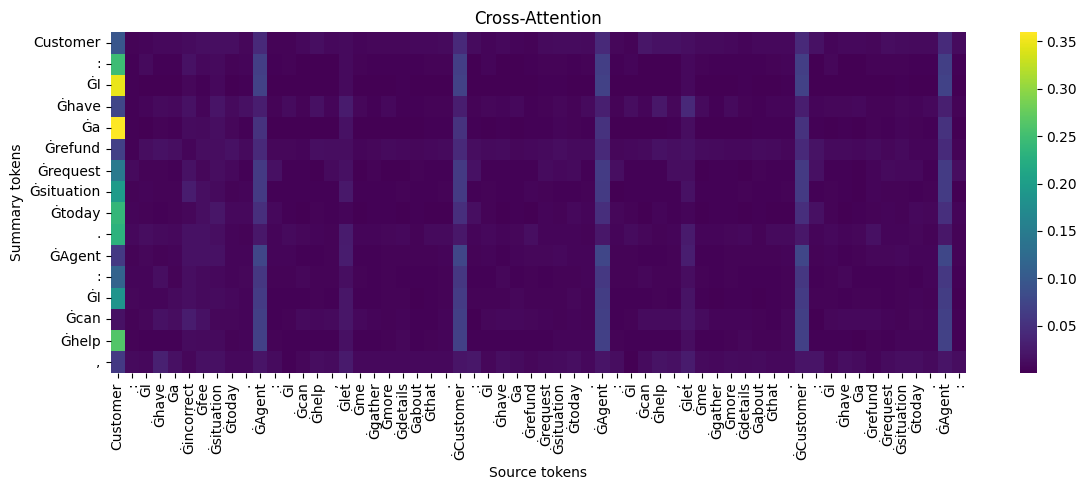

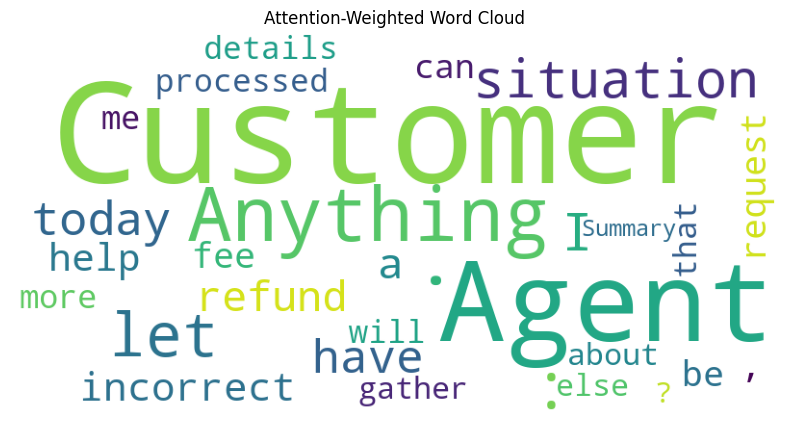

In [13]:
def plot_attention(attn_matrix, inputs, seqs, title='Cross-Attention'):
    if attn_matrix is None:
        print('No attention matrix available.')
        return
    src_tokens, tgt_tokens = decode_tokens(inputs, seqs)
    
    # Ensure matrix is 2D
    if attn_matrix.ndim > 2:
        attn_matrix = attn_matrix.squeeze()
    if attn_matrix.ndim > 2:
        attn_matrix = attn_matrix.mean(axis=0)  # Average over extra dimensions
    
    # limit for display clarity
    src_tokens_disp = src_tokens[:60]
    max_tgt = min(len(tgt_tokens), attn_matrix.shape[0])
    max_src = min(len(src_tokens_disp), attn_matrix.shape[1])
    
    attn_disp = attn_matrix[:max_tgt, :max_src]
    
    plt.figure(figsize=(12,5))
    sns.heatmap(attn_disp, xticklabels=src_tokens_disp[:max_src], yticklabels=tgt_tokens[:max_tgt], cmap='viridis')
    plt.xticks(rotation=90); plt.yticks(rotation=0)
    plt.title(title); plt.xlabel('Source tokens'); plt.ylabel('Summary tokens')
    plt.tight_layout(); plt.show()

def attention_wordcloud(attn_matrix, inputs, seqs):
    if attn_matrix is None: 
        print('No attention matrix available.')
        return
    src_tokens,_ = decode_tokens(inputs, seqs)
    
    # Ensure matrix is 2D and get proper scores
    if attn_matrix.ndim > 2:
        attn_matrix = attn_matrix.squeeze()
    if attn_matrix.ndim > 2:
        attn_matrix = attn_matrix.mean(axis=0)
    
    scores = attn_matrix.sum(axis=0) if attn_matrix.ndim == 2 else attn_matrix
    scores = scores[:len(src_tokens)]
    
    freq={}
    for tok, sc in zip(src_tokens, scores):
        norm = tok.replace('Ġ','').replace('##','')
        if not norm: continue
        freq[norm]=freq.get(norm,0)+float(sc)
    
    if freq:
        wc = WordCloud(width=800,height=400, background_color='white', stopwords=set(STOPWORDS)).generate_from_frequencies(freq)
        plt.figure(figsize=(12,5)); plt.imshow(wc); plt.axis('off'); plt.title('Attention-Weighted Word Cloud'); plt.show()

# Demo on first call
plot_attention(summ_df.attention.iloc[0], summ_df.inputs.iloc[0], summ_df.seqs.iloc[0])
attention_wordcloud(summ_df.attention.iloc[0], summ_df.inputs.iloc[0], summ_df.seqs.iloc[0])

## 13. Drill-Down Report for a Single Call
Combine: summary, source attribution, token importances, sentence importances.

In [14]:
def call_report(call_id:str):
    row = summ_df[summ_df.call_id==call_id].iloc[0]
    print(f'Call ID: {row.call_id} | Type: {row.call_type}')
    print('\nTranscript (truncated):')
    print(textwrap.shorten(row.transcript, width=300))
    print('\nSummary:')
    print(row.summary)
    
    # Source attribution
    attrib = sentence_source_attribution(row.transcript, row.summary, row.attention, row.inputs, row.seqs, top_k=2)
    print('\nSource Attribution:')
    for a in attrib:
        print(f"- Summary sentence: {a['summary_sentence']}")
        for src in a['aligned_sources']:
            print(f"    -> Source: {src['source_sentence']} (score={src['score']:.3f})")
    
    # Token importance
    t_imp = token_importance(row.attention, row.inputs, row.seqs)
    if not t_imp.empty:
        print('\nTop tokens by attention mass:')
        print(t_imp.head(10).to_string(index=False))
    
    s_imp = sentence_importance(row.transcript, t_imp)
    if not s_imp.empty:
        print('\nSentence importance (top 5):')
        print(s_imp.head(5).to_string(index=False))

call_report('call_1')

Call ID: call_1 | Type: billing

Transcript (truncated):
Customer: I have a incorrect fee situation today. Agent: I can help, let me gather more details about that. Customer: I have a refund request situation today. Agent: I can help, let me gather more details about that. Customer: I have a refund request situation today. Agent: Summary: refund [...]

Summary:
Customer: I have a refund request situation today. Agent: I can help, let me gather more details about that . Agent: refund will be processed. Anything else? "I have a incorrect fee situation today," customer says . "I can help," agent says.

Source Attribution:
- Summary sentence: Customer: I have a refund request situation today.
    -> Source: Customer: I have a refund request situation today. (score=5.007)
    -> Source: Customer: I have a refund request situation today. (score=5.007)
- Summary sentence: Agent: I can help, let me gather more details about that .
    -> Source: Agent: I can help, let me gather more details ab

## 14. Aggregate Dashboard (Metrics Distribution)

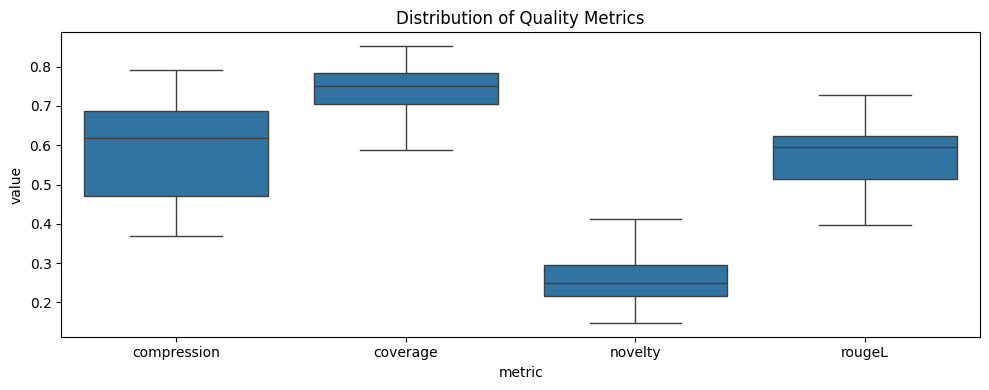

Metrics summary:
       compression   coverage    novelty     rougeL
count    20.000000  20.000000  20.000000  20.000000
mean      0.581230   0.736552   0.263448   0.576863
std       0.143667   0.065686   0.065686   0.085526
min       0.369369   0.588235   0.148148   0.397351
25%       0.469800   0.704672   0.217634   0.514305
50%       0.617647   0.750278   0.249722   0.594308
75%       0.688122   0.782366   0.295328   0.624140
max       0.792453   0.851852   0.411765   0.727273


In [15]:
melted = metrics_df.melt(id_vars='call_id', var_name='metric', value_name='value')
plt.figure(figsize=(10,4))
sns.boxplot(data=melted, x='metric', y='value')
plt.title('Distribution of Quality Metrics')
plt.tight_layout(); plt.show()

print("Metrics summary:")
print(metrics_df.describe())

## 15. Save Artifacts (Optional)

In [16]:
OUTPUT_JSON='summaries_with_attribution.json'
export=[]
for _, r in summ_df.iterrows():
    export.append({
        'call_id':r.call_id,
        'call_type':r.call_type,
        'summary':r.summary,
        'metrics': metrics_df[metrics_df.call_id==r.call_id].iloc[0].to_dict()
    })

with open(OUTPUT_JSON,'w') as f: json.dump(export,f, indent=2)
print('Saved', OUTPUT_JSON)

Saved summaries_with_attribution.json


## 16. Notes & References
* Jain & Wallace (2019) 'Attention is not Explanation'
* DistilBART model: HuggingFace Transformers Hub
* ROUGE: Lin (2004)
* This notebook uses heuristic attribution for educational purposes.